In [213]:
import math
import librosa.feature
import librosa.display
import numpy as np
from IPython.display import Audio, display
import ruptures as rpt  # our package
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio


In [214]:
def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

Loaded signal with shape: (1102500,), Sampling rate: 22050


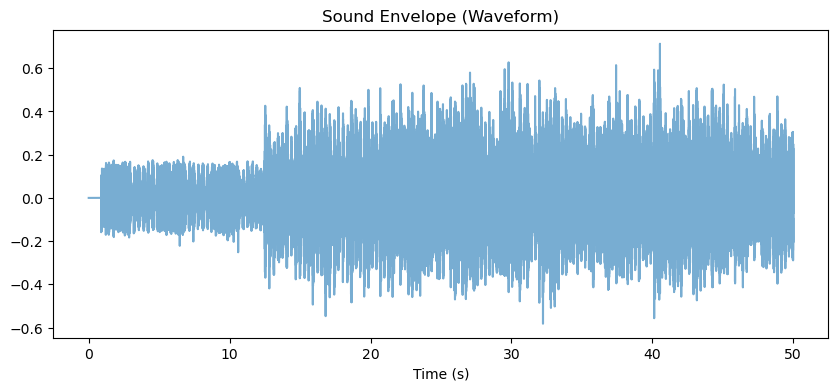

In [215]:
duration = 50
signal, sr = librosa.load(
    r"DO NOT TOUCH/Audio Files/Emmanuel/01. Vitalic.flac",                                                                     # <-- CAN BE CHANGED :))
    duration=duration
)
print(f"Loaded signal with shape: {signal.shape}, Sampling rate: {sr}")

# listen to the music
display(Audio(data=signal, rate=sr))

# Plot waveform
time = np.arange(len(signal)) / sr
plt.figure(figsize=(10, 4))
plt.plot(time, signal, alpha=0.6)
plt.xlabel("Time (s)")
plt.title("Sound Envelope (Waveform)")
plt.show()

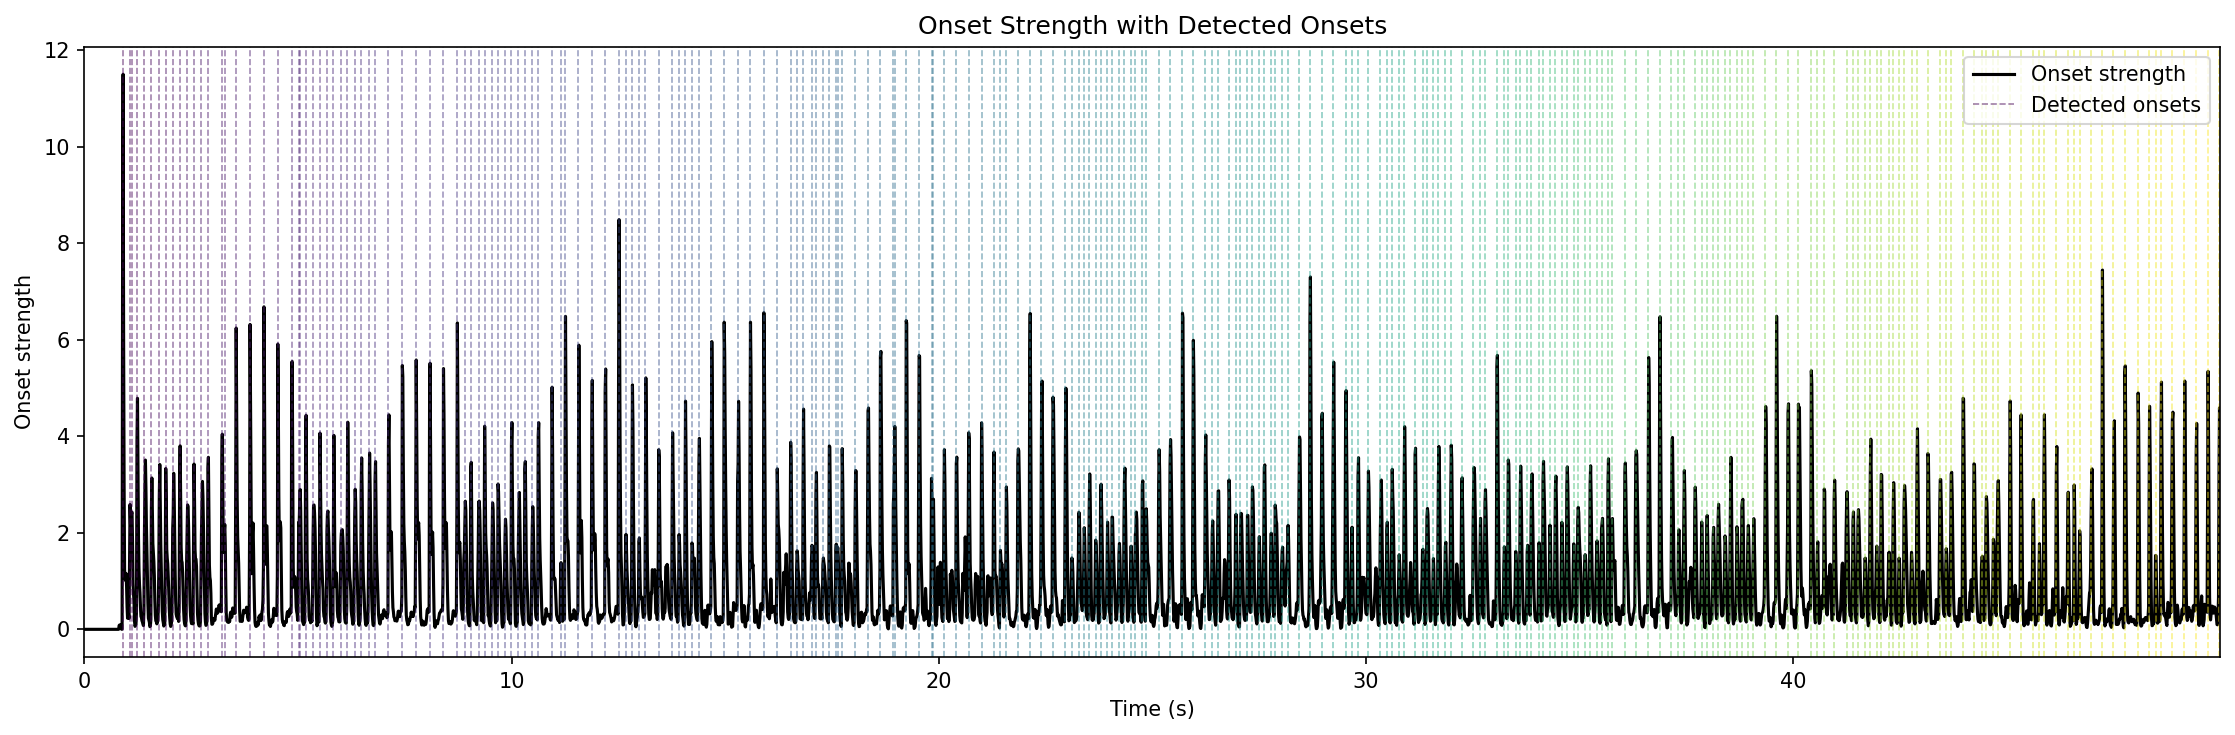

In [216]:

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

# Assume `signal` and `sr` are already defined

# Compute onset strength
hop_length_tempo = 256
oenv = librosa.onset.onset_strength(y=signal, sr=sr, hop_length=hop_length_tempo)

# Detect onset frames
onset_frames = librosa.onset.onset_detect(onset_envelope=oenv, sr=sr, hop_length=hop_length_tempo)

# Convert frames to time
times = librosa.frames_to_time(np.arange(len(oenv)), sr=sr, hop_length=hop_length_tempo)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length_tempo)

# Create plot
fig, ax = fig_ax()
ax.plot(times, oenv, label='Onset strength', color='black')

# Highlight detected onsets with different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(onset_times)))
for onset_time, color in zip(onset_times, colors):
    ax.axvline(onset_time, color=color, linestyle='--', linewidth=0.8, alpha=0.5,)

# Fill the entire x-axis range
ax.set_xlim(times[0], times[-1])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Onset strength')
ax.set_title('Onset Strength with Detected Onsets')
ax.legend(['Onset strength', 'Detected onsets'])
fig.tight_layout()
plt.show()

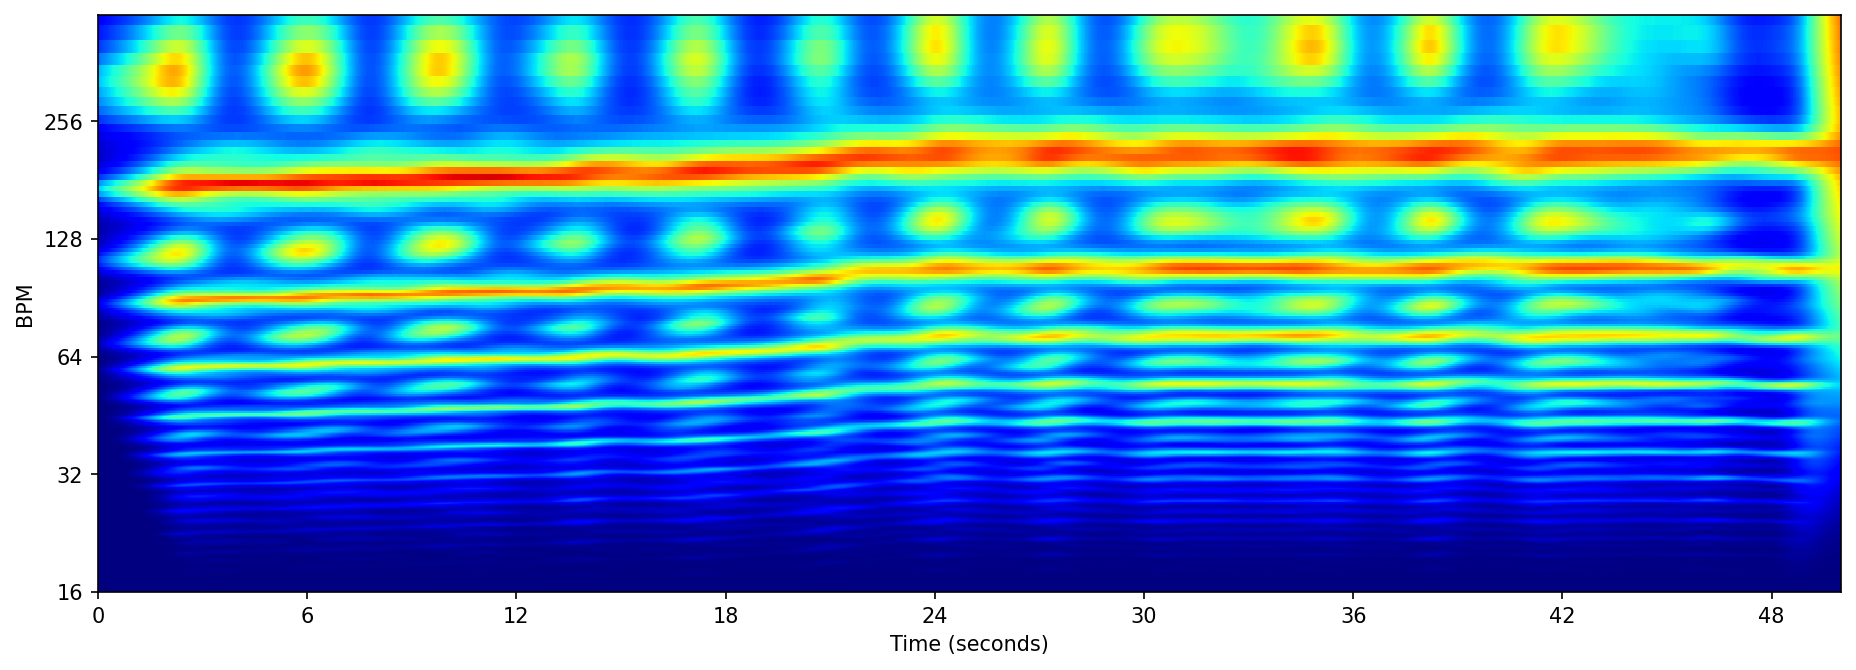

In [217]:
# Compute the tempogram
tempogram = librosa.feature.tempogram(
    onset_envelope=oenv,
    sr=sr,
    hop_length=hop_length_tempo,
)
# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    hop_length=hop_length_tempo,
    sr=sr,
    x_axis="s",
    y_axis="tempo",
    cmap="jet",
)

In [218]:
# Choose detection method TEMPOGRAMS
algoTEM = rpt.KernelCPD(kernel="linear").fit(tempogram.T)                        # <-- CAN BE CHANGED :))

Signal Duration: 50.0 seconds


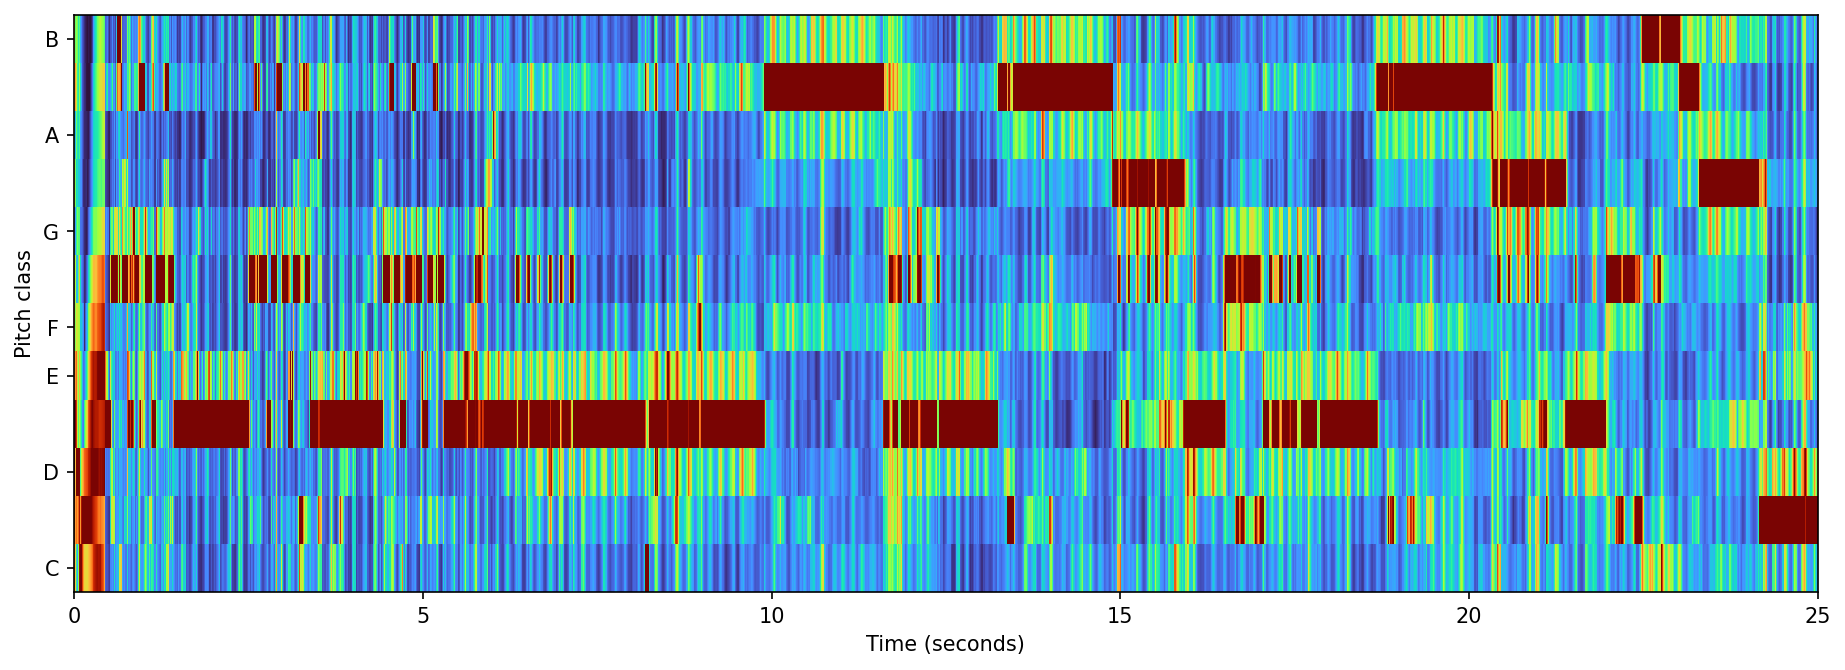

In [219]:
# Compute the Chromagram
# Extract chroma features (try chroma_cqt or chroma_cens)
chroma = librosa.feature.chroma_cqt(y=signal, sr=sr, n_chroma=12)                       # <-- CAN BE CHANGED :))  - Go into the packages.. im sorry..

# Normalize chroma features
chroma = librosa.util.normalize(chroma, axis=1)                       # <-- see if this does anything

# Transpose to shape (time_steps, features)
chroma_T = chroma.T  # shape: (frames, 12)
signal_length_samples = len(signal)
signal_duration_seconds = signal_length_samples / sr
print(f"Signal Duration: {signal_duration_seconds} seconds")

# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    chroma,
    ax=ax,
    hop_length=hop_length_chroma,
    sr=sr,
    x_axis="s",
    y_axis="chroma",
    cmap="turbo",
)

In [220]:
# Choose detection method CHROMAGRAMS
# Changepoint detection with KernelCPD
algoCH = rpt.KernelCPD(kernel="rbf").fit(chroma_T)                            # <-- CAN BE CHANGED :))

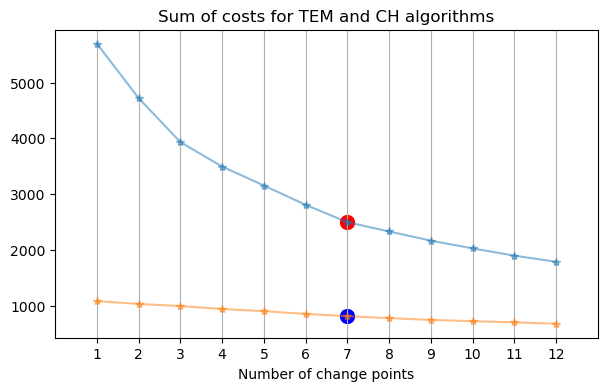

In [221]:
# Choose the number of changes (elbow heuristic)
n_bkps_max = 12  # K_max

# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
_ = algoTEM.predict(n_bkps_max)
_ = algoCH.predict(n_bkps_max)

array_of_n_bkps = np.arange(1, n_bkps_max + 1)

def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

# Plot setup
fig, ax = plt.subplots(figsize=(7, 4))

# Plot for TEM algorithm
ax.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algoTEM, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
    label="TEM",
)

# Plot for CH algorithm
ax.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algoCH, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
    label="CH",
)

ax.set_xticks(array_of_n_bkps)
ax.set_xlabel("Number of change points")
ax.set_title("Sum of costs for TEM and CH algorithms")
ax.grid(axis="x")
ax.set_xlim(0, n_bkps_max + 1)

# Highlight the optimal number of breakpoints (n_bkps=5) for both algorithms
n_bkps = 7
_ = ax.scatter([7], [get_sum_of_cost(algo=algoTEM, n_bkps=7)], color="r", s=100, label="Optimal TEM (n_bkps=7)")
_ = ax.scatter([7], [get_sum_of_cost(algo=algoCH, n_bkps=7)], color="b", s=100, label="Optimal CH (n_bkps=7)")

# Show the plot
plt.show()

In [222]:
# Set the desired number of change points manually                                                                    # <-- CAN BE CHANGED :))
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)

# Now bkps contains the detected change points
print(f"Detected change points Tempo: {bkpsTEM}")

# Predict change points
bkpsCH = algoCH.predict(n_bkps=n_bkps)

print("Detected change points Chroma:", bkpsCH)

Detected change points Tempo: [133, 594, 1201, 1691, 1993, 3928, 4229, 4307]
Detected change points Chroma: [853, 1000, 1141, 1282, 1373, 1610, 1752, 2154]


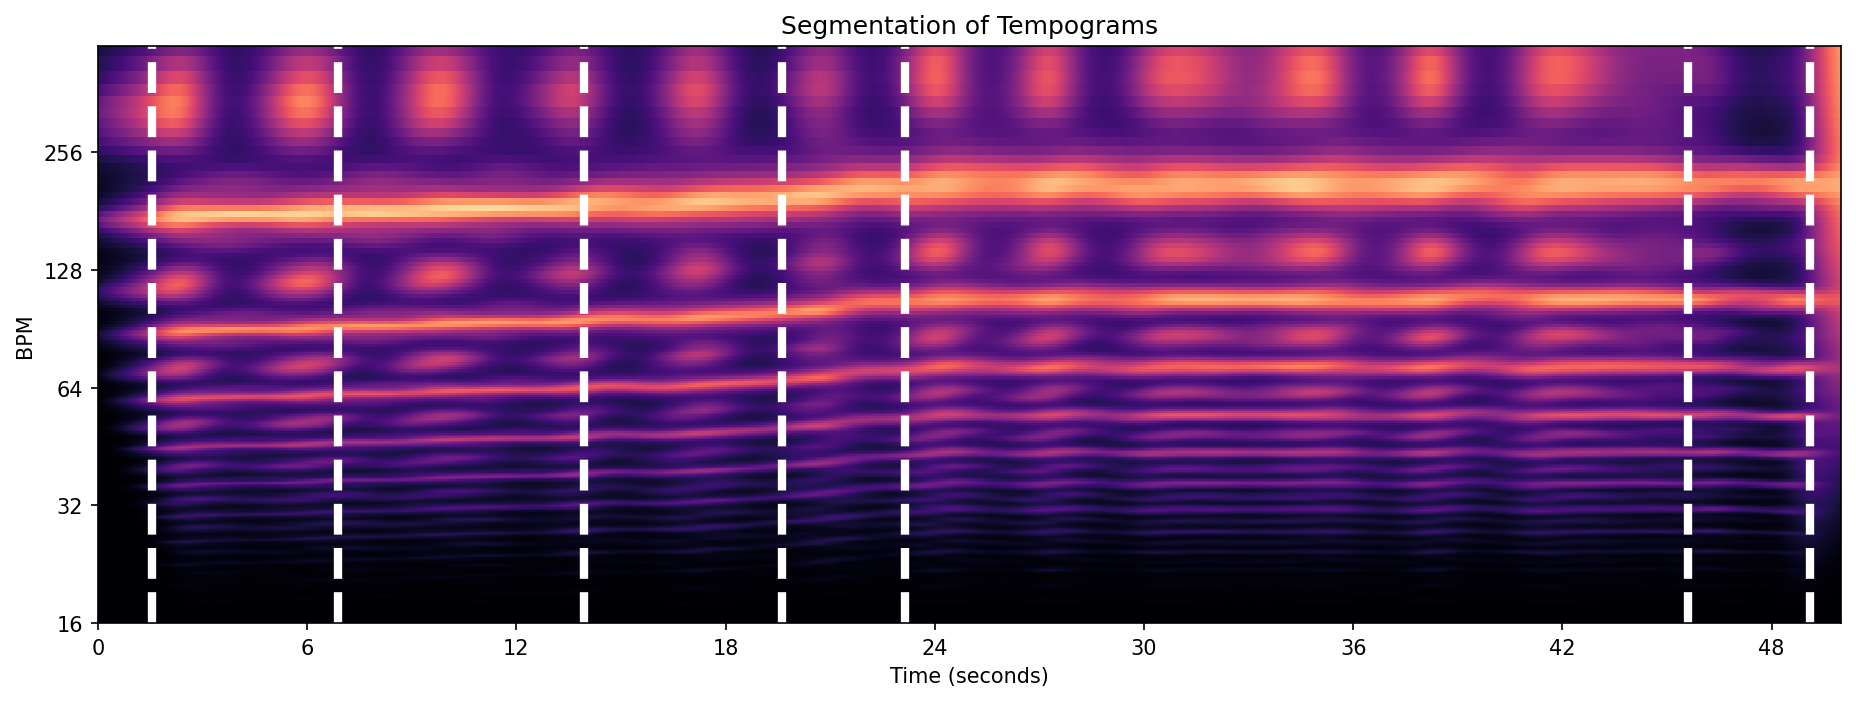

In [223]:
# Segmentation TEMPO
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)
bkps_times = librosa.frames_to_time(bkpsTEM, sr=sr, hop_length=hop_length_tempo)

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    label= "Segmentation of Tempograms",
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sr,
)

# Add title
ax.set_title("Segmentation of Tempograms")

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)

Segmentation at 9.90 seconds
Segmentation at 11.61 seconds
Segmentation at 13.25 seconds
Segmentation at 14.88 seconds
Segmentation at 15.94 seconds
Segmentation at 18.69 seconds
Segmentation at 20.34 seconds


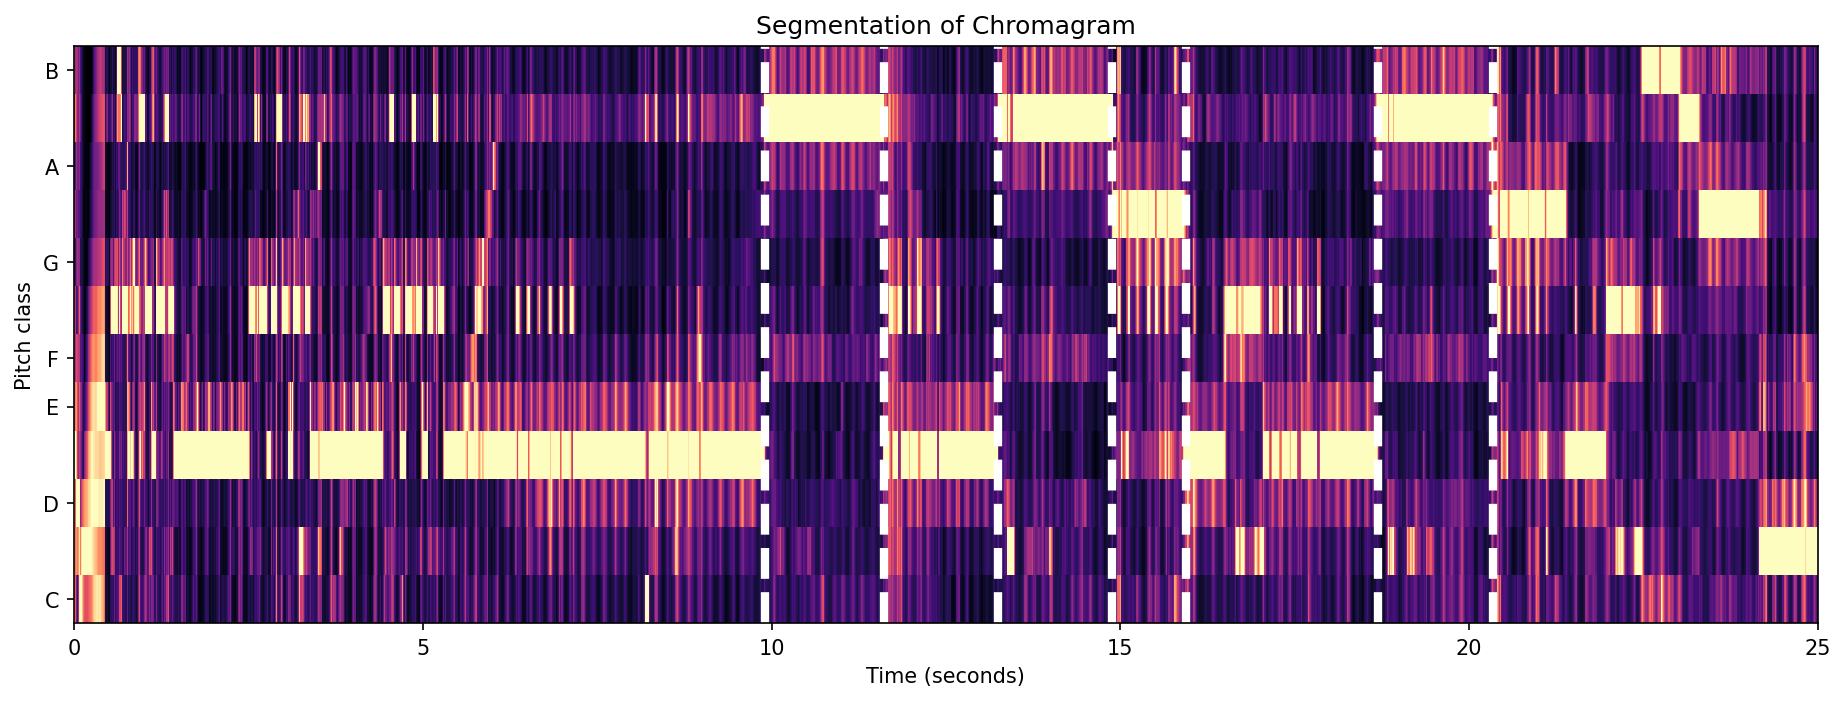

In [224]:
# Segmentation CHROMAGRAM
bkpsCH = algoCH.predict(n_bkps=n_bkps)
bkps_times = librosa.frames_to_time(bkpsCH, sr=sr, hop_length=hop_length_chroma)

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    chroma,
    ax=ax,
    x_axis="s",
    y_axis="chroma",
    hop_length=hop_length_chroma,
    sr=sr,
)

# Add title
ax.set_title("Segmentation of Chromagram")

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)
    print(f"Segmentation at {b:.2f} seconds")


Playing TEMPO-based segments:


Playing CHROMAGRAM-based segments:


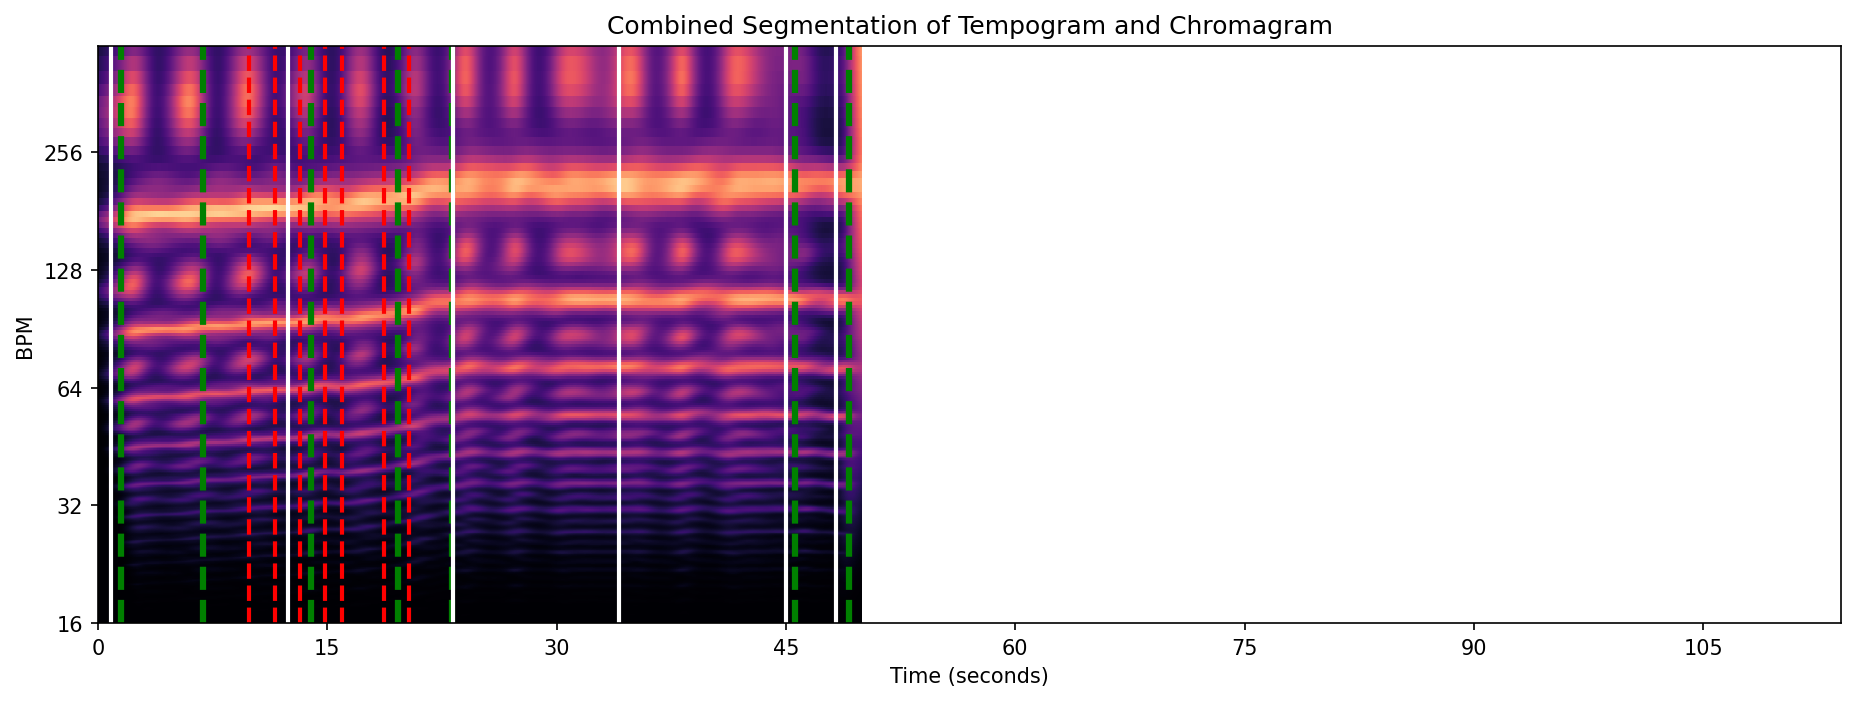

In [225]:
# TEMPO - Breakpoints
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)
bkps_times_TEM = librosa.frames_to_time(bkpsTEM, sr=sr, hop_length=hop_length_tempo)

# CHROMAGRAM - Breakpoints
bkpsCH = algoCH.predict(n_bkps=n_bkps)
bkps_times_CH = librosa.frames_to_time(bkpsCH, sr=sr, hop_length=hop_length_tempo)

# Load Ground Truth Data
GT = "DO NOT TOUCH/GroundTruthData/GroundTruthRight/parsed_data_1.csv"
gt_data = pd.read_csv(GT)

# Extract timestamps from the ground truth
gt_times = gt_data["TIMESTAMP"].values

# Function to split and play segments
def split_and_play_segments(signal, sr, breakpoints):
    """
    Split the audio signal based on breakpoints and play each segment.
    """
    segments = []
    for i in range(1, len(breakpoints)):
        start_sample = librosa.time_to_samples(breakpoints[i-1], sr=sr)
        end_sample = librosa.time_to_samples(breakpoints[i], sr=sr)
        segment = signal[start_sample:end_sample]
        segments.append(segment)
        # Play the segment using IPython's audio display
        display(Audio(segment, rate=sr))
    return segments

# Split and play segments based on TEMPO breakpoints
print("Playing TEMPO-based segments:")
tempo_segments = split_and_play_segments(signal, sr, bkps_times_TEM)

# Split and play segments based on CHROMAGRAM breakpoints
print("Playing CHROMAGRAM-based segments:")
chroma_segments = split_and_play_segments(signal, sr, bkps_times_CH)

# Display the figure with tempogram, segmentation points, and ground truth
fig, ax = fig_ax()

# Display the tempogram as the background
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sr,
)

# Title
ax.set_title("Combined Segmentation of Tempogram and Chromagram")

# TEMPO segmentation points - green dashed lines
for b in bkps_times_TEM[:-1]:
    ax.axvline(b, ls="--", color="green", lw=3, label="Tempo Segmentation" if b == bkps_times_TEM[0] else None)

# CHROMA segmentation points - red dashed lines
for b in bkps_times_CH[:-1]:
    ax.axvline(b, ls="--", color="red", lw=2, label="Chromagram Segmentation" if b == bkps_times_CH[0] else None)

# Ground Truth points - white solid lines
for b in gt_times:
    ax.axvline(b, ls="-", color="white", lw=2, label="Ground Truth" if b == gt_times[0] else None)

plt.show()


In [226]:
# === Your scoring function ===
def gaussian_score_flat_top(time_diff, sigma=0.9, flat_top=0.25):
    abs_diff = abs(time_diff)
    if abs_diff <= flat_top:
        return 100.0
    elif abs_diff >= 3:
        return 0.0
    else:
        adjusted_diff = abs_diff - flat_top
        return 100.0 * math.exp(- (adjusted_diff ** 2) / (2 * sigma ** 2))

# === Load ground truth from CSV ===
ground_truth_path = r"DO NOT TOUCH/GroundTruthData/GroundTruthRight/parsed_data_1.csv"
gt_times = pd.read_csv(ground_truth_path)['TIMESTAMP'].values  # Extract only 'TIMESTAMP' column

# === TEMPO Segmentation ===
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)
bkps_times_TEM = librosa.frames_to_time(bkpsTEM, sr=sr, hop_length=hop_length_tempo)

# === CHROMAGRAM Segmentation ===
bkpsCH = algoCH.predict(n_bkps=n_bkps)
bkps_times_CH = librosa.frames_to_time(bkpsCH, sr=sr, hop_length=hop_length_chroma)

# === Scoring function ===
def evaluate_segmentation(predicted_times, gt_times, label=""):
    scores = []
    matched_preds = []

    for gt in gt_times:
        if len(predicted_times) == 0:
            scores.append(0.0)
            matched_preds.append(None)
            continue
        closest_pred = min(predicted_times, key=lambda p: abs(p - gt))
        matched_preds.append(closest_pred)
        time_diff = closest_pred - gt
        score = gaussian_score_flat_top(time_diff)
        scores.append(score)

    # === Print results ===
    print(f"\n--- Evaluation Results for {label} ---")
    for i, (gt, pred, score) in enumerate(zip(gt_times, matched_preds, scores), 1):
        if pred is not None:
            print(f"{i:02}: GT={gt:.2f}s | Closest Pred={pred:.2f}s | Diff={pred - gt:+.2f}s | Score={score:.2f}")
        else:
            print(f"{i:02}: GT={gt:.2f}s | Closest Pred=None | Diff=None | Score=0.00")

    avg_score = np.mean(scores)
    print(f"\nAverage Score for {label}: {avg_score:.2f}\n")
    return scores, avg_score

# === Evaluate TEMPO ===
tempo_scores, avg_tempo_score = evaluate_segmentation(bkps_times_TEM, gt_times, label="Tempo")

# === Evaluate CHROMAGRAM ===
chroma_scores, avg_chroma_score = evaluate_segmentation(bkps_times_CH, gt_times, label="Chromagram")



--- Evaluation Results for Tempo ---
01: GT=0.88s | Closest Pred=1.54s | Diff=+0.67s | Score=89.82
02: GT=12.47s | Closest Pred=13.94s | Diff=+1.48s | Score=39.45
03: GT=23.21s | Closest Pred=23.14s | Diff=-0.08s | Score=100.00
04: GT=34.09s | Closest Pred=23.14s | Diff=-10.96s | Score=0.00
05: GT=45.02s | Closest Pred=45.60s | Diff=+0.58s | Score=93.31
06: GT=48.28s | Closest Pred=49.10s | Diff=+0.81s | Score=82.20
07: GT=58.10s | Closest Pred=50.00s | Diff=-8.09s | Score=0.00
08: GT=64.93s | Closest Pred=50.00s | Diff=-14.93s | Score=0.00
09: GT=75.87s | Closest Pred=50.00s | Diff=-25.87s | Score=0.00
10: GT=86.75s | Closest Pred=50.00s | Diff=-36.75s | Score=0.00
11: GT=97.67s | Closest Pred=50.00s | Diff=-47.67s | Score=0.00
12: GT=108.59s | Closest Pred=50.00s | Diff=-58.59s | Score=0.00

Average Score for Tempo: 33.73


--- Evaluation Results for Chromagram ---
01: GT=0.88s | Closest Pred=9.90s | Diff=+9.03s | Score=0.00
02: GT=12.47s | Closest Pred=13.25s | Diff=+0.78s | Score=